### GROUP PROJECT<br>
TOPIC: ETL FOR ALIBABA<br>

---

Group Members:<br>
1. FARAH FARINA BINTI AFINDY A188500
2. KHAIRINA BATRISYIA BINTI KHAIRUL ANUAR A193035
3. HANIS NABIHAH BINTI ARIFIN A188202
4. WAN ALEEYA FITRIAH BINTI WAN SHAMSHOL A189547 <br>

In [22]:
!pip install lxml
!pip install requests beautifulsoup4
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
!git clone <https://github.com/farahfarina/alibaba>
%cd <https://github.com/farahfarina/alibaba>

!git add .
!git commit -m "Add Colab notebook and CSV file"

!git push

Names = []
Price = []
Min = []
Company = []
Origin = []
Ratings = []
Verified = []
ProductFeaturesList = []

# Set up the User-Agent header
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

# Function to get soup object
def get_soup(url_with_page):
    response = requests.get(url_with_page, headers=headers)
    return BeautifulSoup(response.content, 'lxml')

# Base URL without the page number
base_url = "https://www.alibaba.com/trade/search?SearchText=Women's%20Perfume"

# Loop through a certain number of pages
for page in range(1, 60):  # Adjust the range as needed
    # Modify the URL with the current page number
    url_with_page = f"{base_url}&page={page}"
    soup = get_soup(url_with_page)

    # Process the page here...
    # For example, find all product names
    names = soup.find_all("h2", class_="search-card-e-title")
    for i in names:
        n = i.text
        Names.append(n)

    prices = soup.find_all("div", class_ = "search-card-e-price-main")
    for i in prices:
      n = i.text
      Price.append(n)

    min = soup.find_all("div", class_ = "search-card-m-sale-features__item")
    for i in min:
      n = i.text
      Min.append(n)

    company = soup.find_all("a", class_ = "search-card-e-company margin-bottom-12")
    for i in company:
      n = i.text
      Company.append(n)

    origin = soup.find_all("a", class_ = "search-card-e-supplier__year")
    for i in origin:
      n = i.text
      Origin.append(n)

    ratings = soup.find_all("span", class_ = "search-card-e-review")
    for i in ratings:
      n = i.text
      Ratings.append(n)

    productFeatList = soup.find_all("div", class_="search-card-m-product-features-list")
    for i in productFeatList:
      n = i.text
      ProductFeaturesList.append(n)


a = {
    "Names": Names,
    "Price": Price,
    "Minimum": Min,
    "Company": Company,
    "Origin": Origin,
    "Ratings": Ratings,
    "Product Features List":ProductFeaturesList
}
df = pd.DataFrame.from_dict(a, orient='index')
df = df.transpose()

print(df)

df.to_csv("alibaba_perfume.csv", index=False)
# Optional: Sleep to avoid overwhelming the server
time.sleep(1)


/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `git clone <https://github.com/farahfarina/alibaba>'
[Errno 2] No such file or directory: '<https://github.com/farahfarina/alibaba>'
/content
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
                                                 Names             Price  \
0    High Quality Lady Original Brand Designer Ligh...     $1.85 - $2.05   
1    Newest fresh and floral body mist long lasting...     $0.95 - $1.09   
2        Fast Delivery Sau-vage Fresh Scent 30mL Spray     $4.30 - $4.80   
3    Clean fragrance natural perfume repair moistur...  $90.00 - $100.00   
4    Victoria's Spray Perfume 50ml Women's Brand Pe...     $1.80 - $2.30   
..                                                 ...               ...   
387                         

In [24]:
import pandas as pd
import re

file_path = "alibaba_perfume.csv"
df = pd.read_csv(file_path)

def extract_minimum_order(text):
    text = str(text)
    match = re.search(r'\d+', text)
    return int(match.group()) if match else None

for col in ['Minimum']:
    df = df[~df[col].str.contains("Shipping|Delivery", na=False)]
    df[col] = df[col].apply(extract_minimum_order)

df = df.rename(columns={'Minimum': 'Minimum Order (Pieces)'})


def extract_numeric(text):
    text = str(text)
    return [float(val) for val in re.findall(r'\d+\.\d+', text)]

lowest_prices = []
highest_prices = []

for price_text in df['Price']:
    numeric_values = extract_numeric(price_text)
    if len(numeric_values) == 1:
        lowest_price = highest_price = float(numeric_values[0])
    elif len(numeric_values) == 2:
        lowest_price, highest_price = map(float, numeric_values)
    lowest_prices.append(lowest_price)
    highest_prices.append(highest_price)

df['Lowest Bulk Price (in $)'] = lowest_prices
df['Highest Bulk Price (in $)'] = highest_prices

ratings = []
num_reviews = []
for rating_text in df['Ratings']:
    rating_match = re.search(r'(\d+\.\d+)/5.0 \((\d+) reviews\)', str(rating_text))
    if rating_match:
        rating, num_review = map(float, rating_match.groups())
        num_review = int(num_review)
    else:
        rating = num_review = None

    ratings.append(rating)
    num_reviews.append(num_review)

df['Rating'] = ratings
df['Number of Reviews'] = df['Ratings'].str.extract(r'(\d+) reviews').astype('Int64')

# Impute missing values
df['Rating'].fillna(df['Rating'].mean(), inplace=True)
df['Rating'] = df['Rating'].round(2)
df['Number of Reviews'].fillna(df['Number of Reviews'].median(), inplace=True)
df['Lowest Bulk Price (in $)'].fillna(df['Lowest Bulk Price (in $)'].mean(), inplace=True)
df['Highest Bulk Price (in $)'].fillna(df['Highest Bulk Price (in $)'].mean(), inplace=True)

missing_origin = df['Origin'].isnull()
df['Years on Amazon'] = df['Origin'].apply(lambda x: re.search(r'(\d+) yr', str(x)).group(1) if pd.notnull(x) and re.search(r'(\d+) yr', str(x)) else None)

country_mapping = {
    'CN': 'China', 'MY': 'Malaysia', 'JP': 'Japan', 'TW': 'Taiwan',
    'TR': 'Turkey', 'PK': 'Pakistan', 'IT': 'Italy', 'ID': 'Indonesia',
    'AE': 'United Arab Emirates', 'EG': 'Egypt', 'IN': 'India'
}
df['Supplier Country Origin'] = df['Origin'].apply(lambda x: re.search(r'yrs(\w+)', str(x)).group(1) if pd.notnull(x) and re.search(r'yrs(\w+)', str(x)) else None)
df['Supplier Country Origin'] = df['Supplier Country Origin'].replace(country_mapping)
df['Supplier Country Origin'].fillna('None', inplace=True)

df = df.dropna(subset=['Names', 'Minimum Order (Pieces)'])
df = df.drop(['Ratings', 'Origin', 'Price', 'Product Features List'], axis=1)

print(df)

cleaned_file_path = "alibaba_perfume_cleaned.csv"
df.to_csv(cleaned_file_path, index=False)


                                                 Names  \
0    High Quality Lady Original Brand Designer Ligh...   
1    Newest fresh and floral body mist long lasting...   
2        Fast Delivery Sau-vage Fresh Scent 30mL Spray   
3    Clean fragrance natural perfume repair moistur...   
4    Victoria's Spray Perfume 50ml Women's Brand Pe...   
..                                                 ...   
228  Premium Quality Glam Style Perfumed EDT mini t...   
230  Women Fragrance AVII HER EDT_Alluring 50ml wit...   
232  Osmanthus Peony Pomegranate fragrance Adjustab...   
233  Wholesale Body Mist Fragrance 236ml Bodyworks ...   
235  Middle East Arab women's perfume trade cross-b...   

     Minimum Order (Pieces)                                          Company  \
0                         3              Zhejiang Meimi Technology Co., Ltd.   
1                       240                         Dwangi Freshener Sdn Bhd   
2                        50                  Japan Healthcare I

HISTOGRAM TO CHECK PRODUCT'S SUPPLIER COUNTRY ORIGIN AND ITS FREQUENCY using pre-cleaned data

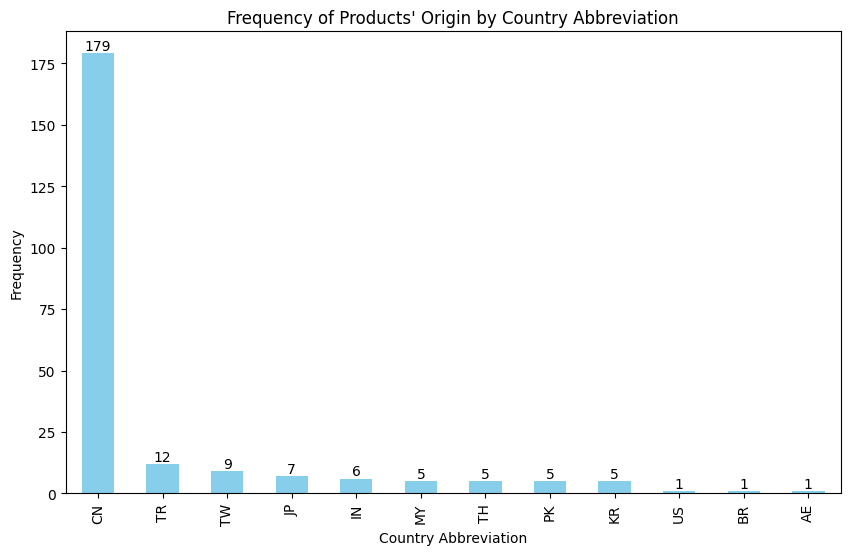

In [25]:

import matplotlib.pyplot as plt

file_path = "alibaba_perfume.csv"
df = pd.read_csv(file_path)

df['CountryAbbreviation'] = df['Origin'].str.extract(r'([A-Z]{2})')
country_counts = df['CountryAbbreviation'].value_counts()

plt.figure(figsize=(10, 6))
ax = country_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Products\' Origin by Country Abbreviation')
plt.xlabel('Country Abbreviation')
plt.ylabel('Frequency')

for i, v in enumerate(country_counts):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.show()


HISTOGRAM TO CHECK PRODUCT'S SUPPLIER COUNTRY ORIGIN AND ITS FREQUENCY using cleaned data

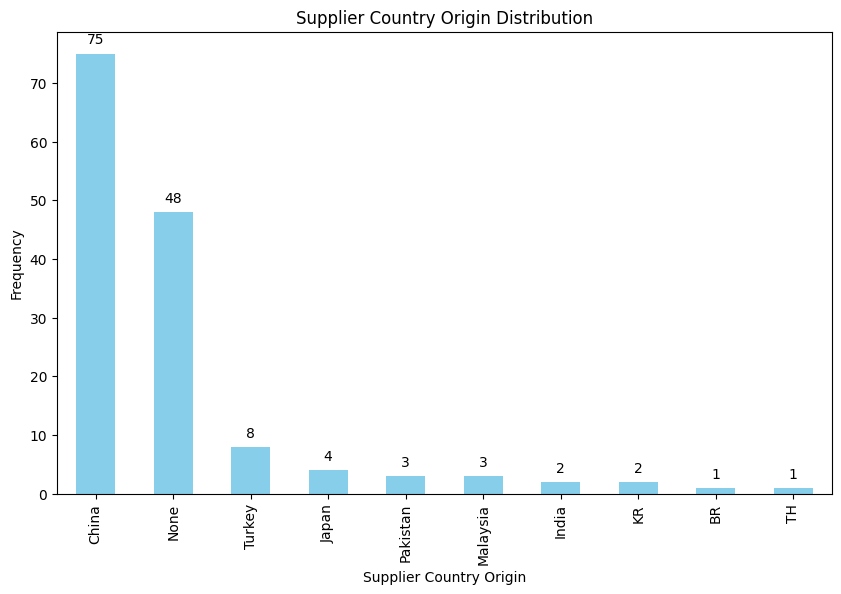

In [26]:
import matplotlib.pyplot as plt

file_path = "alibaba_perfume_cleaned.csv"
df = pd.read_csv(file_path)

# df_filtered = df[df['Supplier Country Origin'] != 'None']

plt.figure(figsize=(10, 6))
ax = df['Supplier Country Origin'].value_counts().plot(kind='bar', color='skyblue') # kalau nak display sekali products yg takde supplier country origin
# ax = df_filtered['Supplier Country Origin'].value_counts().plot(kind='bar', color='skyblue') # kalau xnak display products yg takde supplier country origin

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Supplier Country Origin Distribution')
plt.xlabel('Supplier Country Origin')
plt.ylabel('Frequency')
plt.show()

SCATTERPLOT TO COMPARE PRODUCT'S NUMBER OF REVIEWS AND YEARS ON AMAZON using pre-cleaned data

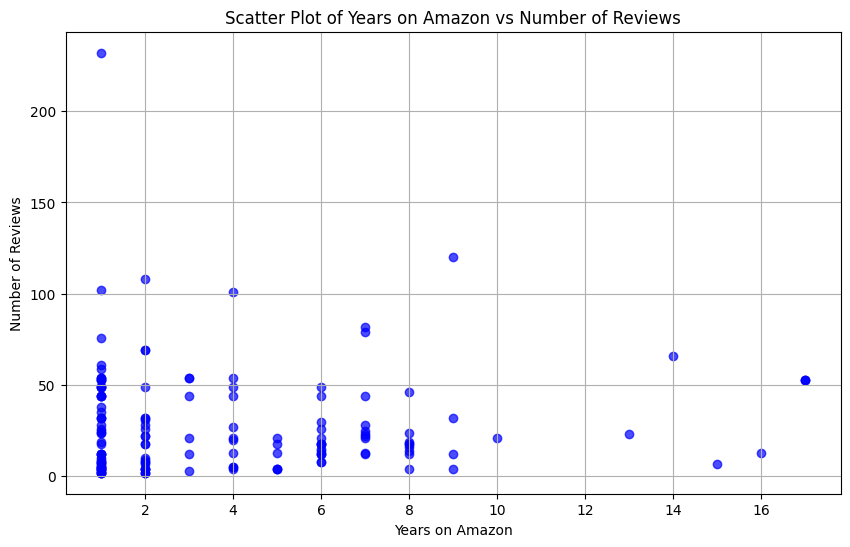

In [27]:

file_path = "alibaba_perfume.csv"
df = pd.read_csv(file_path)
df['Years on Amazon'] = df['Origin'].apply(lambda x: int(re.search(r'(\d+) yr', str(x)).group(1)) if pd.notnull(x) and re.search(r'(\d+) yr', str(x)) else None)
df['Number of Reviews'] = df['Ratings'].apply(lambda x: int(re.search(r'(\d+) reviews', str(x)).group(1)) if pd.notnull(x) and re.search(r'(\d+) reviews', str(x)) else None)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Years on Amazon'], df['Number of Reviews'], color='blue', alpha=0.7)
plt.title('Scatter Plot of Years on Amazon vs Number of Reviews')
plt.xlabel('Years on Amazon')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

SCATTERPLOT TO COMPARE PRODUCT'S NUMBER OF REVIEWS AND YEARS ON AMAZON using cleaned data

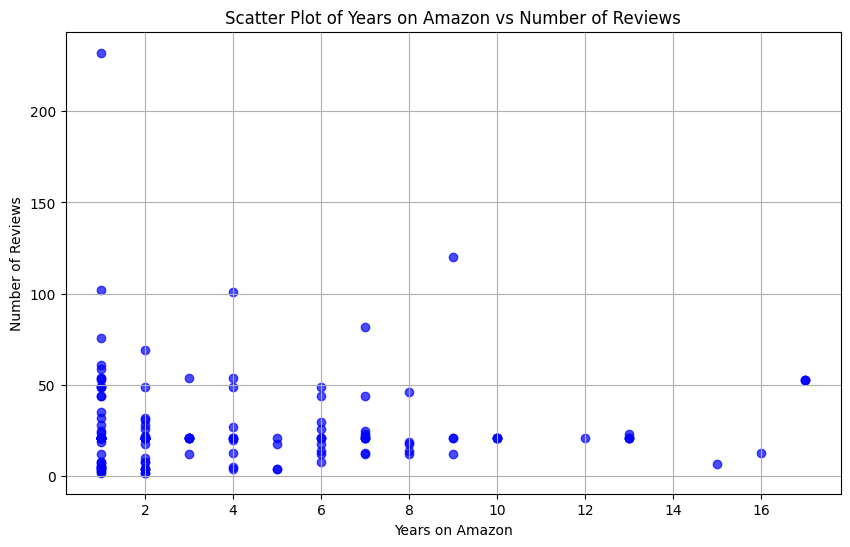

In [28]:

cleaned_file_path = "alibaba_perfume_cleaned.csv"
df = pd.read_csv(cleaned_file_path)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Years on Amazon'], df['Number of Reviews'], color='blue', alpha=0.7)
plt.title('Scatter Plot of Years on Amazon vs Number of Reviews')
plt.xlabel('Years on Amazon')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()


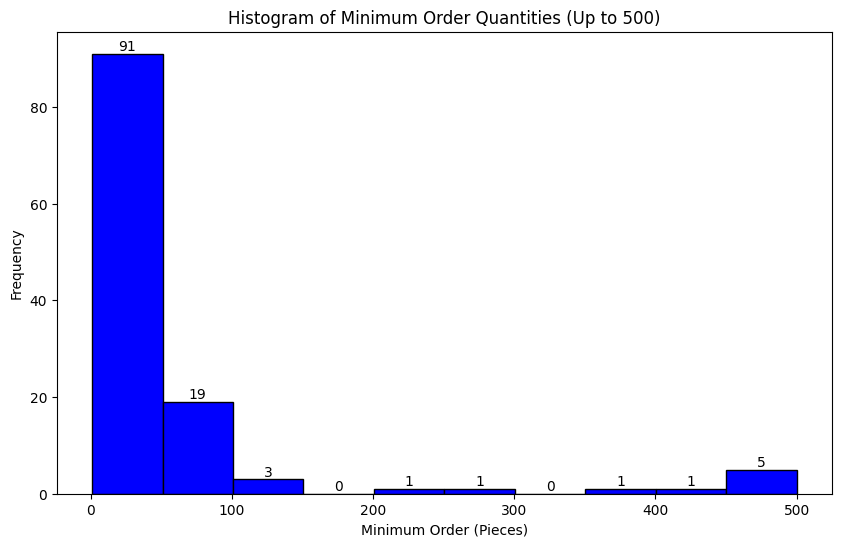

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'alibaba_perfume_cleaned.csv'
df = pd.read_csv(file_path)

# Check if the 'Minimum Order (Pieces)' column exists
if 'Minimum Order (Pieces)' in df.columns:
    # Filter out rows where 'Minimum Order (Pieces)' exceeds 500
    df_filtered = df[df['Minimum Order (Pieces)'] <= 500]

    # Plotting the histogram with filtered data
    plt.figure(figsize=(10, 6))
    hist, bins, _ = plt.hist(df_filtered['Minimum Order (Pieces)'], bins=10, color='blue', edgecolor='black')
    plt.title('Histogram of Minimum Order Quantities (Up to 500)')
    plt.xlabel('Minimum Order (Pieces)')
    plt.ylabel('Frequency')

    # Display the counts above the bars
    for i in range(len(hist)):
        plt.text(bins[i] + (bins[i+1] - bins[i]) / 2, hist[i], str(int(hist[i])), ha='center', va='bottom')

    plt.show()

else:
    print("Column 'Minimum Order (Pieces)' not found in the dataset.")
